In [1]:
suppressPackageStartupMessages(library(emmeans))
suppressPackageStartupMessages(library(car))
suppressPackageStartupMessages(library(effects))
suppressPackageStartupMessages(library(nlme))

# Using GLS in `R`
...


We have seen some examples of using the `gls()` function from `nlme` last semester. At that point, we only focused on the use of the `weights=` argument with different variance structures (e.g. `varIdent()`, `varPower()` etc.). However, there is also a `correlation=` argument that similarly takes a number of pre-specified correlation structures. We can use these two arguments together to form a final variance-covariance matrix that consists of correlation and heterogenous variance groups. 

### The Paired $t$-test Using GLS
We can start with the most simple example of the paired $t$-test using GLS. Importantly, this is an unnecessary step theoretically because the paired $t$-test is a perfectly acceptable technique. When there are only two-repeats there are no arguments about the covariance structure. There can only be a single correlation term. So compound symmetry always works. However, it is useful for us as a *starting point* because it is the simplest example of the problem.

In order to specify a correlation structure, we need to pass one of the predefined correlation functions as an argument to `correlation=`. These structures include functions such as `corCompSymm()`, `corSpher()`, `corAR1()` and `corSymm()`[^corfunc-foot]. For this example, we will use `corCompSymm()`, which constructs a compound symmetric structure.

In order to use `corCompSymm()`, we need to supply it with a description of how we want it structured in relation to our data. This is done using the `form=` argument, which takes a one-sided formula expressing the structure we want. For this example, we will use `corCompSymm(form= ~1|subject)`. This indicates that we want a constant correlation (`1`) grouped by subject (`|subject`). So, the term on the *right* of `|` is key here. This gives a *grouping factor* such that any observations from the same level will share a constant correlation. Because we have used `subject`, each level represents a *different* subject and thus any observations that come from the same subject will be correlated. This therefore defines our *block-diagonal* covariance structure, where the term on the right of `|` forms the *blocks*. We will see ways to visualise this in order to provide more intuition a little later.

Returning to our example, we will use the `mice2` data from `datarium` again, which we have converted to long-format as discussed last week.

In [2]:
library('datarium')
library('reshape2')
data('mice2')

# repeats and number of subjects
t <- 2
n <- dim(mice2)[1]

# reshape wide -> long
mice2.long <- melt(mice2,                       # wide data frame
                   id.vars='id',                # what stays fixed?
                   variable.name="time",        # name for the new predictor
                   value.name="weight")         # name for the new outcome

mice2.long <- mice2.long[order(mice2.long$id),] # order by ID
rownames(mice2.long) <- seq(1,n*t)              # fix row names
mice2.long$id <- as.factor(mice2.long$id)

print(mice2.long)

   id   time weight
1   1 before  187.2
2   1  after  429.5
3   2 before  194.2
4   2  after  404.4
5   3 before  231.7
6   3  after  405.6
7   4 before  200.5
8   4  after  397.2
9   5 before  201.7
10  5  after  377.9
11  6 before  235.0
12  6  after  445.8
13  7 before  208.7
14  7  after  408.4
15  8 before  172.4
16  8  after  337.0
17  9 before  184.6
18  9  after  414.3
19 10 before  189.6
20 10  after  380.3


To fit this model using GLS, we use

In [15]:
library(nlme)

gls.mod <- gls(weight ~ time, correlation=corCompSymm(form=~1|id), data=mice2.long)
lme.mod <- lme(weight ~ time, random=~1|id, data=mice2.long)

library(lme4)
lmer.mod <- lmer(weight ~ time + (1|id), data=mice2.long)


Loading required package: Matrix

Attaching package: ‘lme4’

The following object is masked from ‘package:nlme’:

    lmList



where we can see the use of the `correlation=` argument with the `corCompSymm()` function. We could also optionally include a `weights=` argument if we wanted the diagonal elements of the covariance matrix to differ by `time`. This would take the form `weights=varIdent(form= ~1|time)`. However, we will keep this simple for now.

### Inference Using GLS
Although we should check the assumptions of the GLS model, we will leave that to one side given that we covered it last semester. The more pressing issue for us is to discuss *inference* using the GLS model, especially given the problems highlighted earlier. To begin with, we can treat the returned objects from `gls()` just like an object from `lm()` and call `summary()` to examine the model estimates and tests.

In [4]:
print(summary(gls.mod))

Generalized least squares fit by REML
  Model: weight ~ time 
  Data: mice2.long 
      AIC      BIC    logLik
  177.349 180.9105 -84.67449

Correlation Structure: Compound symmetry
 Formula: ~1 | id 
 Parameter estimate(s):
      Rho 
0.5332493 

Coefficients:
             Value Std.Error  t-value p-value
(Intercept) 200.56  8.081914 24.81591       0
timeafter   199.48  7.808574 25.54628       0

 Correlation: 
          (Intr)
timeafter -0.483

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.46661859 -0.54818094  0.02112903  0.38482224  1.79048964 

Residual standard error: 25.55725 
Degrees of freedom: 20 total; 18 residual


We can see here all the usual output that matches what `lm()` gives us. Indeed, despite what we mentioned earlier, we still get $t$-statistics and $p$-values (though note that the $p$-values are *rounded* rather than displayed using scientific notation). We also have information on the estimated correlation structure, with the single correlation parameter given by $\hat{\rho} = 0.53$. Of most importance is that both the *standard error* and *$t$-value* match what we saw last week from the paired $t$-test. This is evidence enough to show that the correlation *is* being taken into account. Importantly, this is being done within a linear model framework, but *without* the need to subtract the differences *or* to manually partition the errors by including `id` in the model formula.

#### Omnibus Tests and Follow-ups
Putting aside the inferential issues above, the utility of the GLS framework is that we can simply treat the model in the same way as a result from `lm()`. This means we can compute ANOVA-style tests 

In [14]:
#Anova(gls.mod)
Anova(lme.mod)

Analysis of Deviance Table (Type II tests)

Response: weight
      Chisq Df Pr(>Chisq)    
time 652.61  1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

generate confidence intervals (though these should similarly be treated cautiously),

In [6]:
confint(gls.mod)

               2.5 %   97.5 %
(Intercept) 184.7197 216.4003
timeafter   184.1755 214.7845

create plots using the `effects` package

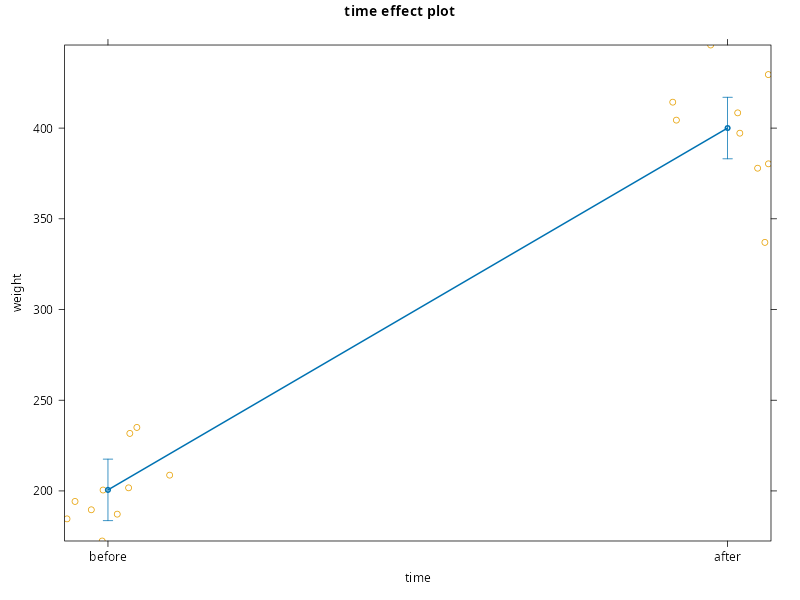

In [7]:
library('effects')
plot(effect('time', gls.mod, residuals=TRUE), partial.residuals=list(smooth=FALSE))

and compute follow-up tests using `emmeans`[^emmeans-foot]

In [8]:
library(emmeans)
emm <- emmeans(gls.mod, pairwise ~ time, mode="asymptotic")
print(emm$contrasts)

 contrast       estimate   SE  df z.ratio p.value
 before - after     -199 7.81 Inf -25.546  <.0001

Degrees-of-freedom method: asymptotic 


All the additional options supported by different model classes when using `emmeans` are available online as an [alphabetical list](https://cran.r-project.org/web/packages/emmeans/vignettes/models.html).

So, if we put the inferential issues to one side, we can see that GLS provides a nice alternative to the repeated measures ANOVA because it exists within the linear model framework and thus allows us to use all the methods we have seen previously. Furthermore, we can lift the assumption of compound symmetry and use a variety of different covariance matrices. The main downside is that this comes with a price in terms of the $p$-value not taking the uncertainty in the estimation of the covariance structure into account. This is especially problematic in *small samples*, which means we should really treat the hypothesis tests from a GLS model as only *asymptotically correct*. If we are happy to do so, GLS becomes quite a useful method to have on hand. We will see a few more examples of using GLS with more complex ANOVA models in the associated workshop.

## One-way ANOVA Using GLS

## Viewing the Estimated Covariance Structure

[^weights-foot]: This is why the argument in `gls()` was `weights=`.

[^corfunc-foot]: You can look up descriptions of all of these using `?corClasses` at the prompt. 

[^white-foot]: This is sometimes known as *whitening* the data. This is a term you may come across in the neuroimaging literature, particularly in relation to how fMRI is analysed.

[^emmeans-foot]: The `mode=` option has been set to `df.error` so that the reported test matches the table from `summary()`. `emmeans` actually has some better ways of adjusting the degrees of freedom to accommodate the uncertainty in estimating $\boldsymbol{\Sigma}$, but this is a complication we will leave to one side for now.